In [2]:
import os
import pandas as pd


In [3]:
image_path = "/kaggle/input/flickr30k/flickr30k_images"
# /kaggle/input/flickr30k/flickr30k_images
caption_path = '/kaggle/input/flickr30k/captions.txt'
print(len(os.listdir(image_path)))

31783


In [4]:
data = pd.read_csv(caption_path)
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
import numpy as np

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications.xception import Xception,preprocess_input #to get pre-trained model Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-07-09 16:46:56.233699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 16:46:56.233821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 16:46:56.359405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
xmodel = Xception(weights='imagenet', include_top=False,pooling='avg')
# model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# img_size = 299
# features = {}
# for image in tqdm(data['image_name'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = np.expand_dims(img,axis=0)
#     img = img/127.5
#     img = img - 1.0
#     feature = model.predict(img, verbose=0)
#     features[image] = feature

In [8]:
import pickle


# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [9]:
with open('/kaggle/input/features/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [10]:
print(len(features))

31783


In [11]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

In [12]:
data  = text_preprocessing(data)
captions  = data['comment'].tolist()
captions[:10]



['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
print(max_length)


74


In [14]:
print(vocab_size)

18319


In [15]:
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,startseq two young guys with shaggy hair look ...
1,1000092795.jpg,1,startseq two young white males are outside nea...
2,1000092795.jpg,2,startseq two men in green shirts are standing ...
3,1000092795.jpg,3,startseq man in blue shirt standing in garden ...
4,1000092795.jpg,4,startseq two friends enjoy time spent together...


In [16]:
data.drop(columns=['comment_number'],axis =1,inplace=True)
data.head()

,image_name,comment
0,1000092795.jpg,startseq two young guys with shaggy hair look ...
1,1000092795.jpg,startseq two young white males are outside nea...
2,1000092795.jpg,startseq two men in green shirts are standing ...
3,1000092795.jpg,startseq man in blue shirt standing in garden ...
4,1000092795.jpg,startseq two friends enjoy time spent together...


In [17]:
from sklearn.model_selection import train_test_split

train_images, val_images = train_test_split(data['image_name'].unique().tolist(), test_size=0.15, random_state=42)


train = data[data['image_name'].isin(train_images)].reset_index(drop=True)
val = data[data['image_name'].isin(val_images)].reset_index(drop=True)


print(f"Total images: {len(data['image_name'].unique())}")
print(f"Training images: {len(train_images)}, Training samples: {len(train)}")
print(f"Validation images: {len(val_images)}, Validation samples: {len(val)}")

Total images: 31783
Training images: 27015, Training samples: 135075
Validation images: 4768, Validation samples: 23840


In [18]:
tokenizer.texts_to_sequences([captions[1]])


[[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]]

In [19]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [20]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

In [ ]:

# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.utils import plot_model
# def define_model(vocab_size, max_length):
#     inputs1 = Input(shape=(2048,))
#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(512, activation='relu')(fe1)
#     fe2 = BatchNormalization()(fe2)
#     fe2 = Dropout(0.5)(fe2)
#     fe3 = Dense(256, activation='relu')(fe2)
#     img_features_reshaped = Reshape((1, 256), input_shape=(256,))(fe3)

    
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
#     merge = concatenate([img_features_reshaped,se1],axis=1)
#     se2 = Dropout(0.5)(merge)
#     se3 = LSTM(512, return_sequences=True)(se2)
#     se3 = Dropout(0.5)(se3)
#     se4 = LSTM(256)(se3)
    
#     decoder1 = add([fe3, se4])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     decoder2 = BatchNormalization()(decoder2)
#     decoder2 = Dropout(0.5)(decoder2)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)

#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)
#     return model


# model = define_model(vocab_size, max_length)


In [19]:
from tensorflow.keras.layers import BatchNormalization, Input, Dropout, Dense, Reshape, Embedding, concatenate, LSTM, add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    fe2 = BatchNormalization()(fe2)
    fe2 = Dropout(0.5)(fe2)
    fe3 = Dense(256, activation='relu')(fe2)
    img_features_reshaped = Reshape((1, 256), input_shape=(256,))(fe3)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    merge = concatenate([img_features_reshaped, se1], axis=1)
    se2 = Dropout(0.5)(merge)
    se3 = LSTM(512, return_sequences=True)(se2)
    se3 = Dropout(0.5)(se3)
    
    # Add prebuilt attention layer here
    attention = Attention()([se3, se3])
    
    se4 = LSTM(256)(attention)
    
    decoder1 = add([fe3, se4])
    decoder2 = Dense(256, activation='relu')(decoder1)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Dropout(0.5)(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

model_attention = define_model(vocab_size, max_length)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,689,664 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 75, 256)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 75, 512)   │  1,574,912 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 75, 512)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 75, 512)   │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    787,456 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18319)     │  4,707,983 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,009,295 (49.63 MB)

 Trainable params: 13,007,759 (49.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


In [21]:
train_generator = CustomDataGenerator(df=train,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=val,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [21]:
model_name = "model_attention.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
history =model_attention.fit(
        train_generator,
        epochs=9,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])


Epoch 1/9
  56/2110 ━━━━━━━━━━━━━━━━━━━━ 34:10 998ms/step - loss: 9.7592

In [22]:
from tensorflow.keras.models import load_model

# Path to the uploaded model file or directory
model_path = '/kaggle/input/new-attn/model_attention.keras'
# If you saved the model in a directory
# model_path = '/kaggle/input/your-uploaded-model-directory/model_directory'

# Load the model
model = load_model(model_path)

In [23]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model,img,tokenizer,max_length,features):
    feature = features[img]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence],verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 
    



In [40]:
samples = val.sample(10)
samples.reset_index(drop=True,inplace=True)

In [41]:
# generated_captions =[]
# reference_captions=[]
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image_name']),target_size=(299,299))
    img = img_to_array(img)
    img = img/127.5
    img = img-1
    
    caption = predict_caption(model, record['image_name'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
#     generated_captions.append(caption)  # Append caption
#     reference_captions.append([record['comment']]) 
    

In [37]:
# import nltk
# from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


# nltk.download('punkt')


# generated_captions_tokenized = [nltk.word_tokenize(caption) for caption in generated_captions]
# reference_captions_tokenized = [[nltk.word_tokenize(ref) for ref in refs] for refs in reference_captions]

# # Compute BLEU scores
# corpus_bleu_score = corpus_bleu(reference_captions_tokenized, generated_captions_tokenized)

# # Print BLEU scores
# print("Corpus BLEU Score:", corpus_bleu_score)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Corpus BLEU Score: 0.0323672537352749


In [42]:
samples

,image_name,comment,caption
0,526328385.jpg,startseq red and yellow roller coaster car on ...,startseq man in red shirt is standing on the s...
1,4486660330.jpg,startseq three men wearing hats are seated at ...,startseq man in white shirt and blue jeans is ...
2,4665599368.jpg,startseq boy walking wearing uniform endseq,startseq man in white shirt and black pants is...
3,3173690688.jpg,startseq the lady in the black dress is standi...,startseq man in blue shirt is standing on rock...
4,5352303362.jpg,startseq woman stands at podium that reads sva...,startseq man in black shirt is speaking into m...
5,3093533301.jpg,startseq demonstration for very strongly held ...,startseq people walking down busy street endseq
6,2884092603.jpg,startseq the young girl is given rabbit ears b...,startseq young boy in blue shirt and blue jean...
7,3640104986.jpg,startseq the elaborate jesus shrine is being c...,startseq man in white shirt is standing in fro...
8,2102538696.jpg,startseq young asian girls running track endseq,startseq two men are playing basketball endseq
9,3563668905.jpg,startseq person is riding bike on dirt road en...,startseq man in red helmet is riding bike endseq


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


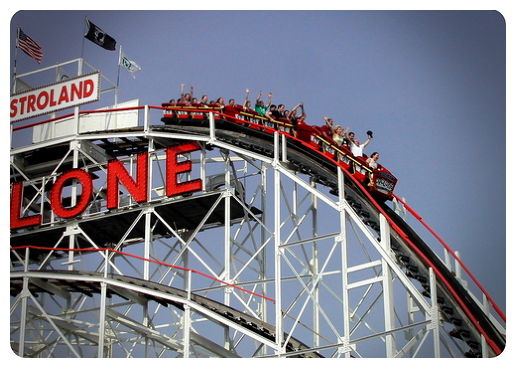

Real Caption: startseq red and yellow roller coaster car on white track is about to go down hill with many passengers raising their hands endseq
Generated Caption: startseq man in red shirt is standing on the side of the street endseq
BLEU Score: 0.4065

--------------------------------------------------



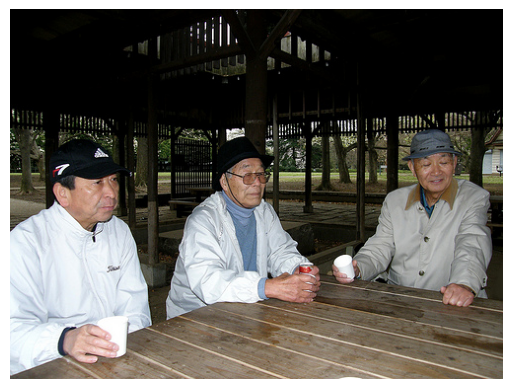

Real Caption: startseq three men wearing hats are seated at table under an enclosure in garden endseq
Generated Caption: startseq man in white shirt and blue jeans is standing in front of an old building endseq
BLEU Score: 0.6965

--------------------------------------------------



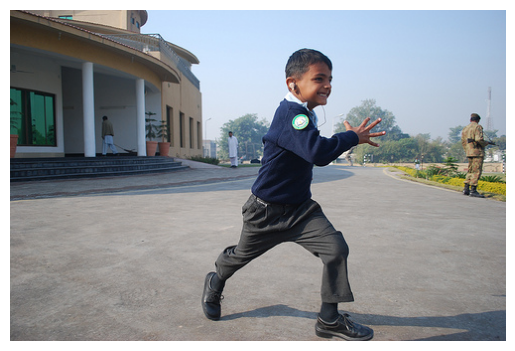

Real Caption: startseq boy walking wearing uniform endseq
Generated Caption: startseq man in white shirt and black pants is walking down the street endseq
BLEU Score: 0.6804

--------------------------------------------------



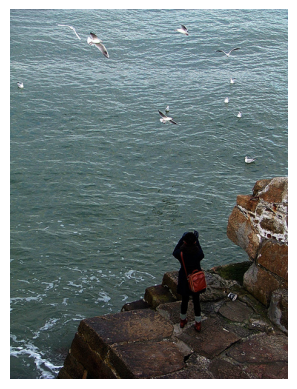

Real Caption: startseq the lady in the black dress is standing near the edge of the cliff taking pictures endseq
Generated Caption: startseq man in blue shirt is standing on rock overlooking the water endseq
BLEU Score: 0.3015

--------------------------------------------------



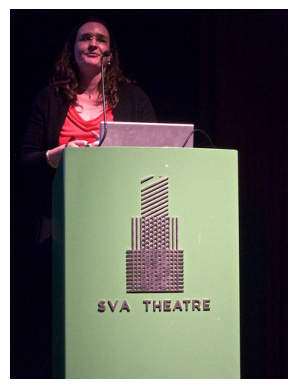

Real Caption: startseq woman stands at podium that reads sva theatre endseq
Generated Caption: startseq man in black shirt is speaking into microphone endseq
BLEU Score: 0.6687

--------------------------------------------------



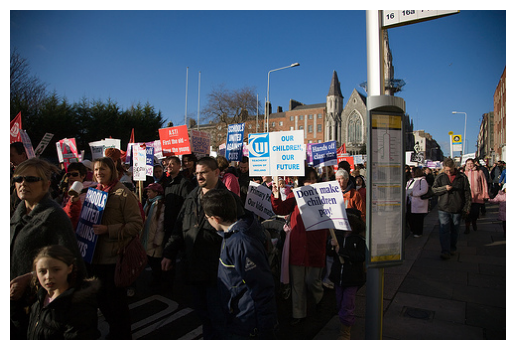

Real Caption: startseq demonstration for very strongly held point of view endseq
Generated Caption: startseq people walking down busy street endseq
BLEU Score: 0.4763

--------------------------------------------------



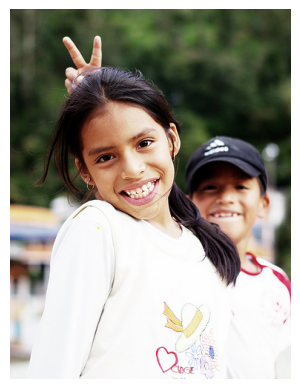

Real Caption: startseq the young girl is given rabbit ears by the young boy behind her endseq
Generated Caption: startseq young boy in blue shirt and blue jeans is holding baby endseq
BLEU Score: 0.3628

--------------------------------------------------



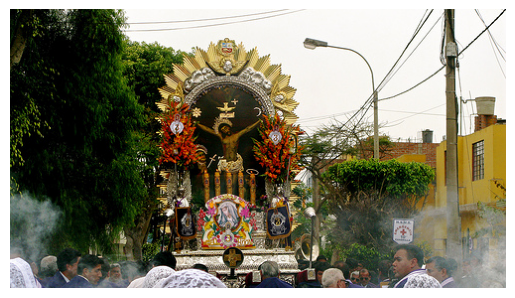

Real Caption: startseq the elaborate jesus shrine is being carried in parade endseq
Generated Caption: startseq man in white shirt is standing in front of large building endseq
BLEU Score: 0.7448

--------------------------------------------------



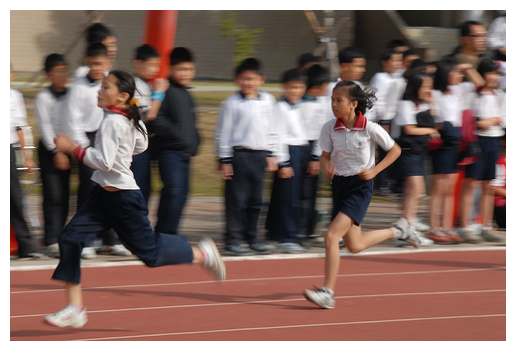

Real Caption: startseq young asian girls running track endseq
Generated Caption: startseq two men are playing basketball endseq
BLEU Score: 0.7311

--------------------------------------------------



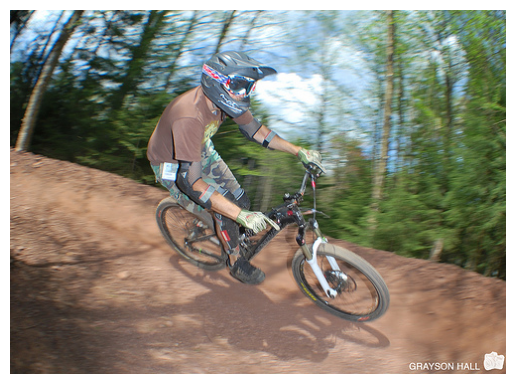

Real Caption: startseq person is riding bike on dirt road endseq
Generated Caption: startseq man in red helmet is riding bike endseq
BLEU Score: 0.3753

--------------------------------------------------



In [43]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Assuming you have a DataFrame 'samples' with columns 'image_name', 'comment' (real caption), and 'caption' (generated caption)
# Ensure you have downloaded the necessary NLTK data
nltk.download('punkt')

# Define a function to compute BLEU score
def compute_bleu(real_caption, generated_caption):
    reference = [nltk.word_tokenize(real_caption)]
    candidate = nltk.word_tokenize(generated_caption)
    score = sentence_bleu(reference, candidate)
    return score


for index, record in samples.iterrows():
    img = Image.open(os.path.join(image_path, record['image_name']))
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print(f"Real Caption: {record['comment']}")
    print(f"Generated Caption: {record['caption']}")
    
    bleu_score = compute_bleu(record['comment'], record['caption'])
    print(f"BLEU Score: {bleu_score:.4f}")
    print("\n" + "-"*50 + "\n")

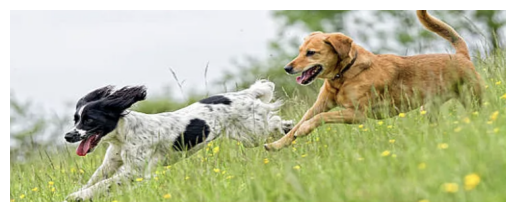

black dog is running through the grass


In [46]:
from PIL import Image
def create_caption(img_path, model, xmodel, tokenizer, max_length, img_size):
 
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')  
    plt.show()
    img = img.resize((img_size, img_size))
    img = np.array(img)
    
    img = np.expand_dims(img, axis=0)
    img = img/127.5
    img = img - 1.0
    
#     img = xmodel.preprocess_input(img)
    
   
    feature = xmodel.predict(img, verbose=0)
    
  
    in_text = 'startseq'
    
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        

        word = idx_to_word(y_pred, tokenizer)
        

        in_text += ' ' + word
        

        if word == 'endseq':
            break
    
   
    caption = in_text.split()[1:-1]
    caption = ' '.join(caption)
    
    return caption



caty_path = "/kaggle/input/capybar/cap.png"
cap = create_caption(caty_path, model, xmodel, tokenizer, max_length, 299)
print(cap)
# img_size = 299
# img = Image.open(caty_path)
# img = img.resize((img_size, img_size))
# img = np.array(img)
# img = np.expand_dims(img, axis=0)
# print(img.shape)